import dependencies

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
from pandas.plotting import scatter_matrix
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

Appending all the dataset into a list

In [2]:
data = []
fileNum = 2
while fileNum < 115: 
    with open('data/logs-insights-results-' + str(fileNum) + '.csv') as f:
        for line in csv.DictReader(f, fieldnames=('timestamp', 'message')):
            data.append(line)
        fileNum += 1

In [3]:
len(data)

822226

In [4]:
print(data[0])

{'timestamp': '@timestamp', 'message': '@message'}


This following decodes to message into different attributes:
<li>account: the account of the user </li>
<li>sourceIP: the ip address of the sender of the message</li>
<li>destIP: the receiver of the message</li>
<li>interface: the log stream of the message</li>
<li>srcPort: internet port of sender</li>
<li>dstPort: internet port of receiver</li>
<li>protocol: the network protocol used to communicate the message</li>
<li>byte: the size of the message</li>
<li>packets: number of segments of the message</li>
<li>startTime: the integer start time in unix time form</li>
<li>timeTook: exact time it took to send the message</li>
<li>status: either "ACCEPT" or "REJECT". Accept will be 1 and reject will be represented as 0.</li>

In [5]:
date = []
time = []
account = []
sourceIP = []
destIP = []
interface = []
srcPort = []
dstPort = []
protocol = []
byte = []
packets = []
startTime = []
timeTook = []
status = []

na = None
i = 1

while i < len(data):
    msg = data[i].get('message',na)
    # for messages with no data will get filtered out here
    if 'ACCEPT' in msg or 'REJECT' in msg:
        timeTokens = data[i].get('timestamp',na).split()
        date.append(timeTokens[0])
        time.append(timeTokens[1])
        tokens = msg.split()
        account.append(tokens[1])
        interface.append(tokens[2])
        sourceIP.append(tokens[3])
        destIP.append(tokens[4])
        #storing actions
        temp = 5
        tempStr = ''
        while(tokens[temp+1] != "OK"):
            tempStr = tempStr + tokens[temp] + ' '
            temp += 1
        actionTokens = tempStr.split()
        srcPort.append(actionTokens[0])
        dstPort.append(actionTokens[1])
        protocol.append(actionTokens[2])
        packets.append(actionTokens[3])
        byte.append(actionTokens[4])
        startTime.append(int(actionTokens[5]))
        timeTook.append(int(actionTokens[6]) - int(actionTokens[5]))
        if(tokens[temp] == 'ACCEPT'):
            status.append(1)
        else:
            status.append(0)
    i += 1
# print label as well
print('Date: ' + date[0])
print('Time: ' + time[0])
print('AWS account: ' + account[0])
print('Network interface: ' + interface[0])
print('Source IP: ' + sourceIP[0])
print('Destination IP: ' + destIP[0])
print('Status: ' + str(status[0]))
print('Source port: ' + srcPort[0])
print('Destination port: ' + dstPort[0])
print('Protocol: ' + protocol[0])
print('Packets of data: ' + packets[0])
print('Size of data: ' + byte[0] + ' bytes')
print('Start time: ' + str(startTime[0]))
print('Time used: ' + str(timeTook[0]) + ' seconds')
print('New size of dataset after filtering: ' + str(len(date)))

Date: 2021-02-10
Time: 18:15:00.000
AWS account: 430405884063
Network interface: eni-0b6ce86ea40aaa41b
Source IP: 50.245.225.205
Destination IP: 172.16.1.52
Status: 1
Source port: 9622
Destination port: 80
Protocol: 6
Packets of data: 5
Size of data: 582 bytes
Start time: 1612980900
Time used: 9 seconds
New size of dataset after filtering: 813100


Creating the pandas dataframe

In [6]:
df = pd.DataFrame({
    "date":date,
    "time":time,
    "account":account,
    "interface":interface,
    "sourceIP":sourceIP,
    "destIP":destIP,
    "srcPort":srcPort,
    "dstPort":dstPort,
    "protocol":protocol,
    "packets":packets,
    "byte":byte,
    "startTime":startTime,
    "timeTook":timeTook,
    "status":status
})

In [7]:
df.head(10)

,date,time,account,interface,sourceIP,destIP,srcPort,dstPort,protocol,packets,byte,startTime,timeTook,status
0,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,50.245.225.205,172.16.1.52,9622,80,6,5,582,1612980900,9,1
1,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,172.16.1.52,50.245.225.205,80,9622,6,5,689,1612980900,9,1
2,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,50.245.225.205,172.16.1.52,22050,80,6,6,648,1612980900,9,1
3,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,172.16.1.52,50.245.225.205,80,22050,6,5,582,1612980900,9,1
4,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,50.245.225.205,172.16.1.52,51466,80,6,8,723,1612980900,9,1
5,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,172.16.1.52,50.245.225.205,80,51466,6,11,10996,1612980900,9,1
6,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,50.245.225.205,172.16.1.52,49748,80,6,7,705,1612980900,9,1
7,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,172.16.1.52,50.245.225.205,80,49748,6,13,12958,1612980900,9,1
8,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,50.245.225.205,172.16.1.52,18681,80,6,5,572,1612980900,9,1
9,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,172.16.1.52,50.245.225.205,80,18681,6,5,638,1612980900,9,1


In [8]:
df.columns

Index(['date', 'time', 'account', 'interface', 'sourceIP', 'destIP', 'srcPort',
       'dstPort', 'protocol', 'packets', 'byte', 'startTime', 'timeTook',
       'status'],
      dtype='object')

Remove features that are not interested

In [9]:
df.pop('date')
df.pop('time')
df.pop("account")
df.pop("interface")
df.pop('srcPort')
df.pop('dstPort')
df.pop('protocol')
df.pop('packets')
df.pop('byte')
df.pop('timeTook')

# Reformat numbers
df['startTime'] = pd.to_numeric(df['startTime'])
df['status'] = pd.to_numeric(df['status'])

df.head()

,sourceIP,destIP,startTime,status
0,50.245.225.205,172.16.1.52,1612980900,1
1,172.16.1.52,50.245.225.205,1612980900,1
2,50.245.225.205,172.16.1.52,1612980900,1
3,172.16.1.52,50.245.225.205,1612980900,1
4,50.245.225.205,172.16.1.52,1612980900,1


Sorting the values by time, source ip address, and destination ip address for data pre-process

In [10]:
df = df.sort_values(['startTime','sourceIP', 'destIP',],ascending=[True, True, True])
df = df.reset_index(drop=True)
df.head()

,sourceIP,destIP,startTime,status
0,172.16.1.196,172.16.1.52,1612980720,1
1,172.16.1.196,172.16.1.52,1612980720,1
2,172.16.1.196,172.16.1.52,1612980720,1
3,172.16.1.196,172.16.1.52,1612980720,1
4,172.16.1.196,172.16.1.52,1612980720,1


Because an attacked is considered as an abnormal behavior in the dataset which the number of requests from a single ip address is much greater than the average. We combine the rows if the source IP, destination IP, and start time are the same, creating a new column called numOfRequest that keeps track of the number of duplicate requests for each second, and acceptanceRate that summerize the total accuracy of ACCEPT/REJECT

In [11]:
#preprocess the data
#O(n)
processedDf = pd.DataFrame({
    "sourceIP":[],
    "destIP":[],
    "numOfRequest":[],
    "time":[],
    "acceptanceRate":[],
})
for index, line in df.iterrows():
    if index == 0:
        m = 100
        if line['status'] == 0:
            m = 0
        processedDf.loc[0] = [line['sourceIP'],line['destIP'],1,line['startTime'],m]
    else:
        n = len(processedDf)-1
        if processedDf.loc[n,'sourceIP']==line['sourceIP'] and processedDf.loc[n,'destIP']==line['destIP'] and processedDf.loc[n,'time']==line['startTime']:
            x = processedDf.loc[n,'numOfRequest']
            processedDf.loc[n,'numOfRequest'] = x + 1
            if line['status'] == 1:
                processedDf.loc[n,'acceptanceRate'] = (((x*processedDf.loc[n,'acceptanceRate']*0.01)+1)/(x+1)) * 100
            else:
                processedDf.loc[n,'acceptanceRate'] = (((x*processedDf.loc[n,'acceptanceRate']*0.01))/(x+1)) * 100
        else:
            m = 100
            if line['status'] == 0:
                m = 0
            processedDf.loc[n+1] = [line['sourceIP'],line['destIP'],1,line['startTime'],m]
processedDf.head()

,sourceIP,destIP,numOfRequest,time,acceptanceRate
0,172.16.1.196,172.16.1.52,5.0,1.612981e+09,100.0
1,172.16.1.52,172.16.1.196,5.0,1.612981e+09,100.0
2,172.16.1.52,50.230.35.38,4.0,1.612981e+09,100.0
3,50.230.35.38,172.16.1.52,4.0,1.612981e+09,100.0
4,10.3.252.99,172.16.1.196,5.0,1.612981e+09,100.0


In [12]:
processedDf.to_csv('processed_data.csv')

View data to determine correlations, groupings, outliers, and any other trends (only 5% of the data graphed)

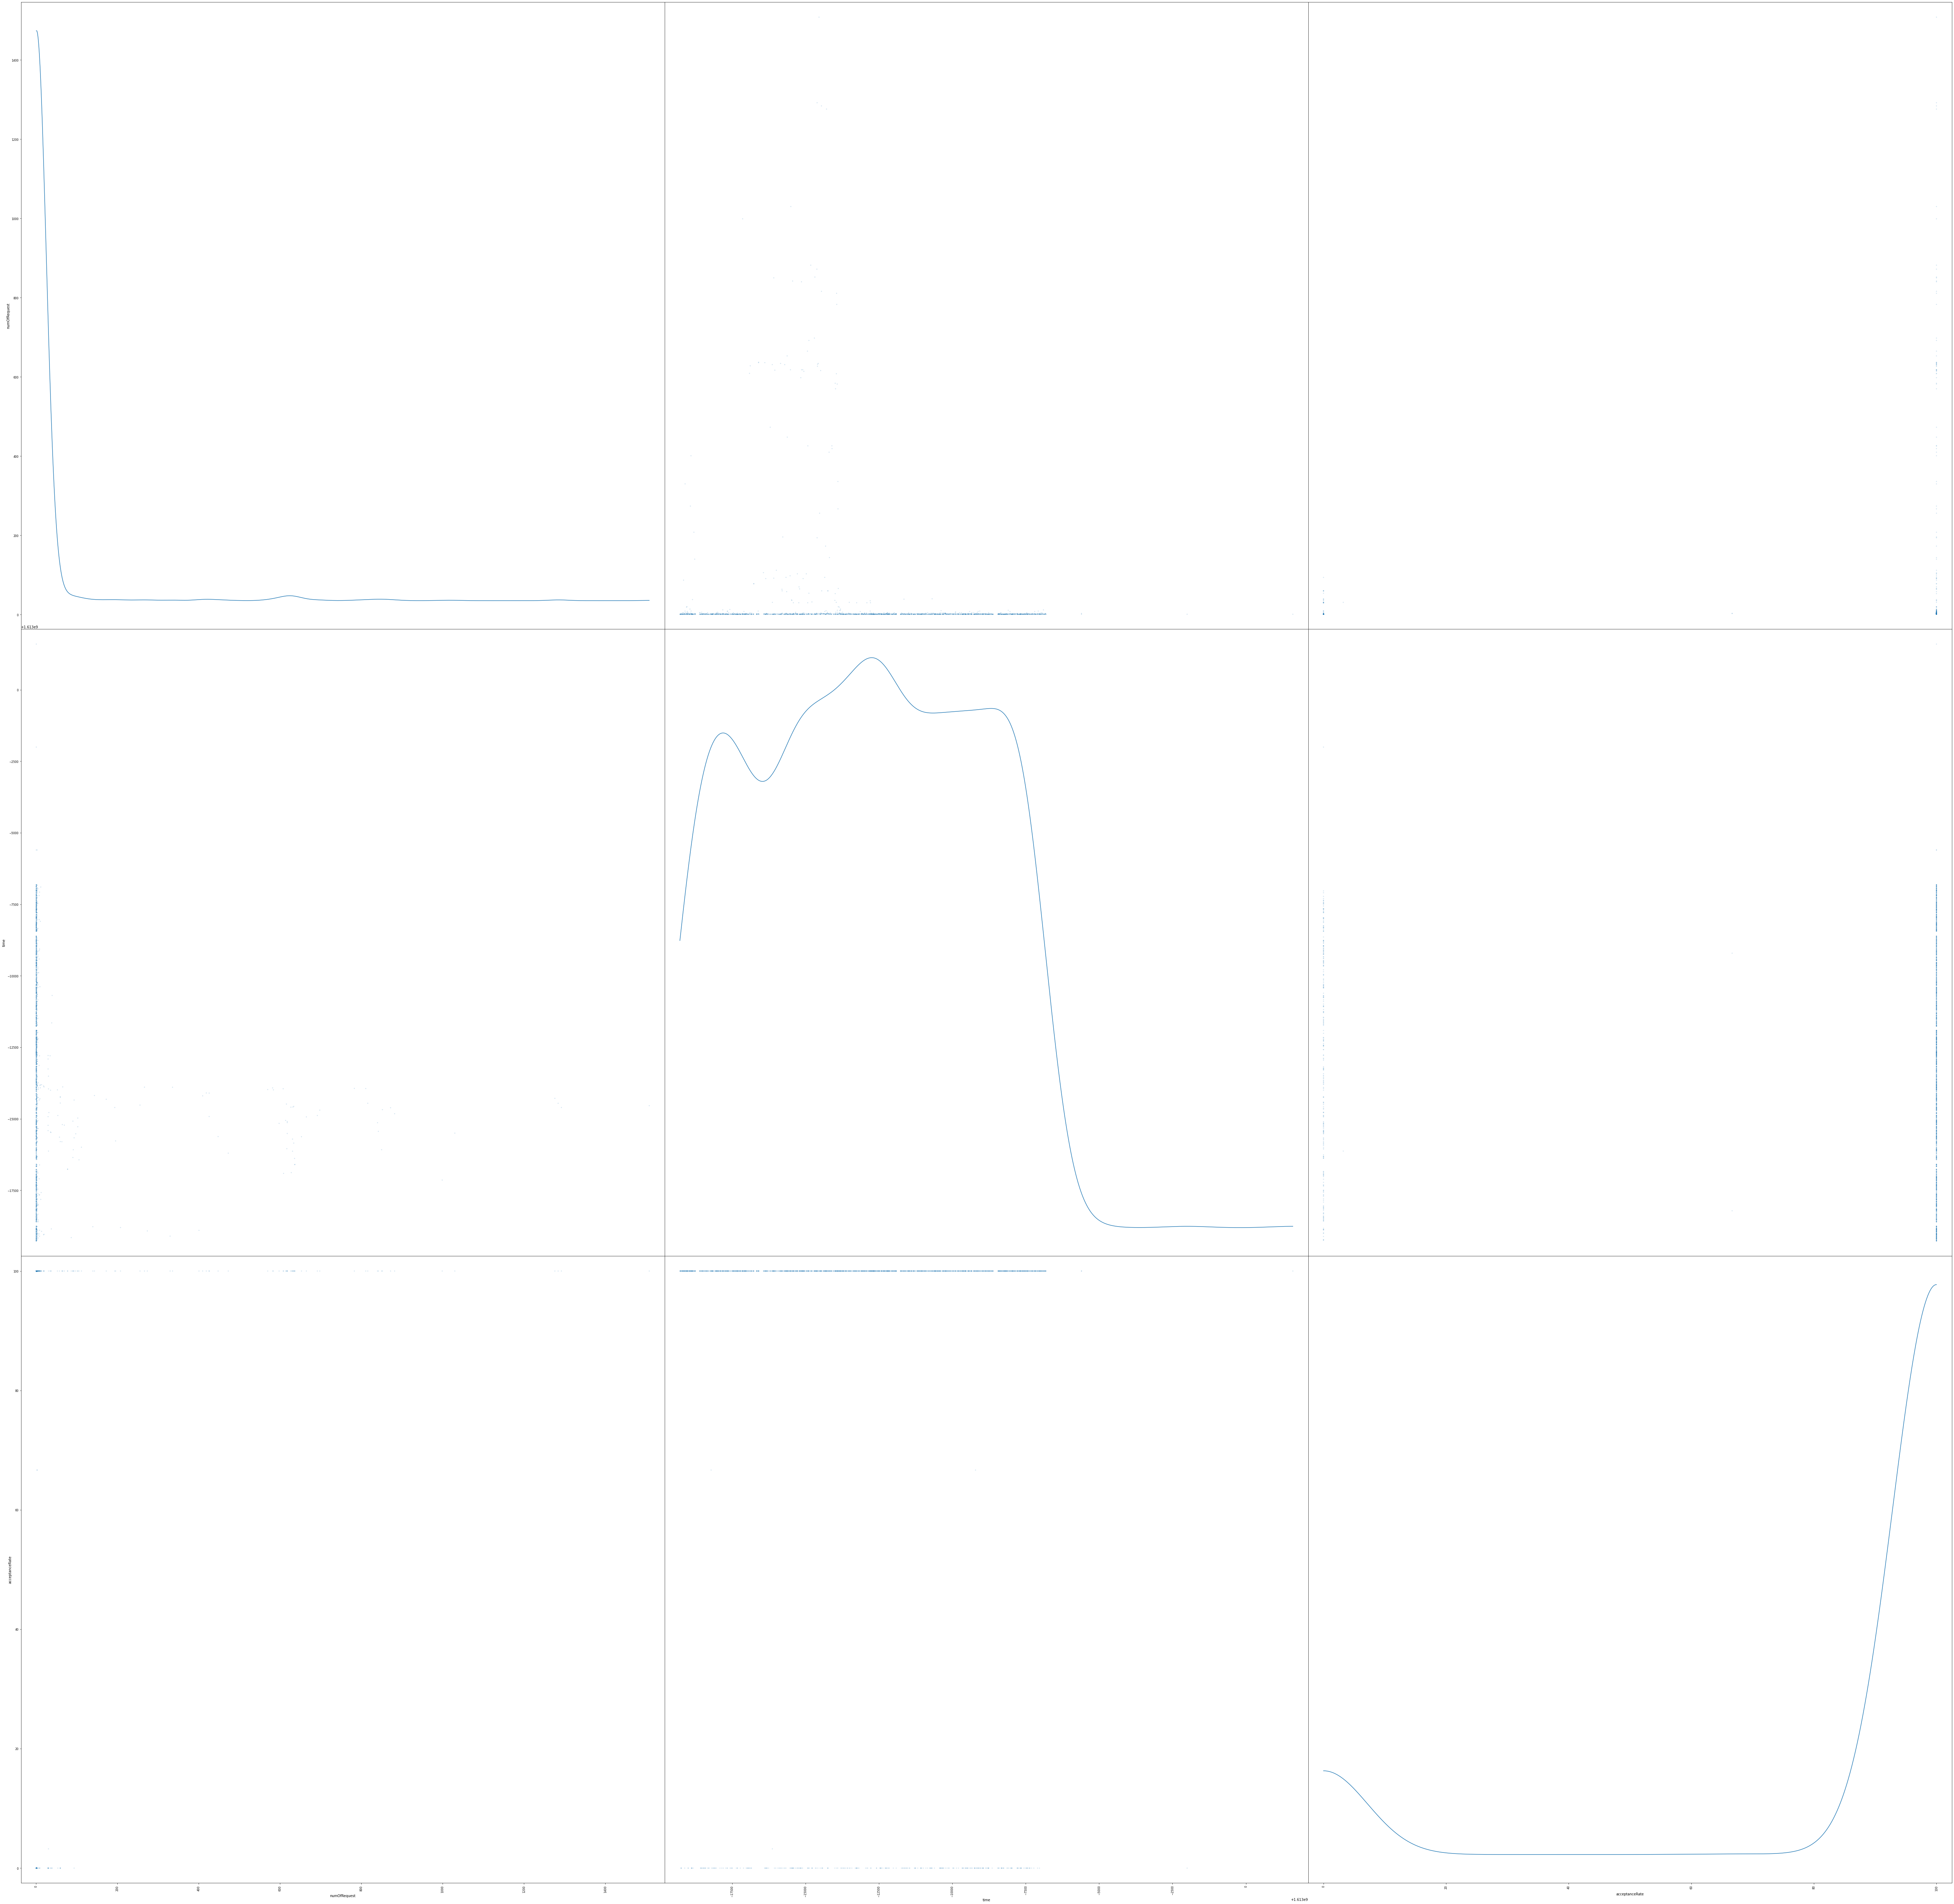

In [13]:
fig = scatter_matrix(processedDf.sample(frac=0.05), alpha=0.2,figsize=(100,100), diagonal="kde")  

In [14]:
df = processedDf    

Because the dataset does not contain a supervised information to determine the response being whether an attack, unsupervised machine learning is used to determine the attacks and not attacks. KMeans clustering groups the the dataset around 2 centroids. Then, logistic regression is used to produce the likeihood of each response being an attack by the machine. The K-mean cluster result is used as a superviser for the logictic regression.

In [15]:
from numpy import nan
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

# This is our dataset to train, tweak, and test our model on.
X = df.loc[:, ['numOfRequest', 'acceptanceRate']]

#unsupervised learning using k-means clustering
kmeans = KMeans(n_clusters = 2) # is attack or not attack into 2 clusters
kmeans.fit(X)
df['is_attack'] = kmeans.labels_

#supervised learning using logictic regression
y = df['is_attack'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, verbose=1).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14412
           1       1.00      1.00      1.00       278

    accuracy                           1.00     14690
   macro avg       1.00      1.00      1.00     14690
weighted avg       1.00      1.00      1.00     14690



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


The report above indicated that there are 14386 responsed considered as not attacks, and 288 as attacks.

In [16]:
df['is_attack_supervised'] = clf.predict_proba(X)[:,1]
df.head()

,sourceIP,destIP,numOfRequest,time,acceptanceRate,is_attack,is_attack_supervised
0,172.16.1.196,172.16.1.52,5.0,1.612981e+09,100.0,0,1.958992e-147
1,172.16.1.52,172.16.1.196,5.0,1.612981e+09,100.0,0,1.958992e-147
2,172.16.1.52,50.230.35.38,4.0,1.612981e+09,100.0,0,7.856866e-148
3,50.230.35.38,172.16.1.52,4.0,1.612981e+09,100.0,0,7.856866e-148
4,10.3.252.99,172.16.1.196,5.0,1.612981e+09,100.0,0,1.958992e-147


Here is the sorted dataset based on the probability of attacks, the result is showing that for over a few hundred responses in 1 second are highly considered an attack.

In [17]:
attacks = df.sort_values(by='is_attack_supervised',ascending=False)
attacks = attacks[attacks['is_attack_supervised']==1]
attacks['likelihood'] = attacks['numOfRequest']/attacks['numOfRequest'].max()
attacks.to_csv('attacks.csv')
attacks.head()

,sourceIP,destIP,numOfRequest,time,acceptanceRate,is_attack,is_attack_supervised,likelihood
10907,172.16.1.52,172.16.1.196,622.0,1.612984e+09,100.0,1,1.0,0.258091
14408,172.16.1.52,172.16.1.196,655.0,1.612985e+09,100.0,1,1.0,0.271784
14399,172.16.1.52,172.16.1.196,650.0,1.612985e+09,100.0,1,1.0,0.269710
14397,172.16.1.196,172.16.1.52,650.0,1.612985e+09,100.0,1,1.0,0.269710
14366,172.16.1.52,172.16.1.196,579.0,1.612985e+09,100.0,1,1.0,0.240249


The threshold for the number of requests considered as an attack is 410 per second

In [18]:
attacks.sort_values(by='numOfRequest',ascending=True)

,sourceIP,destIP,numOfRequest,time,acceptanceRate,is_attack,is_attack_supervised,likelihood
862,172.16.1.52,50.245.225.205,416.0,1.612981e+09,100.000000,1,1.0,0.172614
863,50.245.225.205,172.16.1.52,416.0,1.612981e+09,100.000000,1,1.0,0.172614
14636,172.16.1.196,172.16.1.52,417.0,1.612985e+09,100.000000,1,1.0,0.173029
10398,172.16.1.52,172.16.1.196,417.0,1.612984e+09,100.000000,1,1.0,0.173029
10397,172.16.1.196,172.16.1.52,417.0,1.612984e+09,100.000000,1,1.0,0.173029
...,...,...,...,...,...,...,...,...
16871,172.16.1.52,172.16.1.196,1866.0,1.612986e+09,100.000000,1,1.0,0.774274
15122,10.3.252.33,172.16.1.241,1965.0,1.612985e+09,0.152672,1,1.0,0.815353
18923,10.3.252.33,172.16.1.241,2034.0,1.612986e+09,0.245821,1,1.0,0.843983
17697,172.16.1.52,172.16.1.196,2410.0,1.612986e+09,100.000000,1,1.0,1.000000


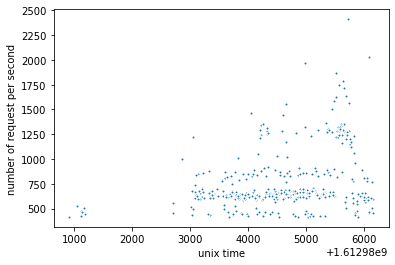

In [21]:
plt.scatter(attacks['time'], attacks['numOfRequest'], marker='.', edgecolors='white')
plt.xlabel("unix time")
plt.ylabel("number of request per second")
plt.show()

In [22]:
df.to_csv('result.csv')

The idea of detecting web attacks through machine learning is not a brand new topic, but an area that still needs better development and research on. This project analyzied around 8000000 log flow records from a company in a 5 hour range. After pre-process its data, the machine detected some records being potential attacks and gave its likeihood.

The project first process the data into pandas dataframe, then omit all the features of the record that are not interested in detecting the attacks. Next, the data is being compressed from 8000000 datas to around 17000 by combining the records that has the same source and destination ip address in the same unix time. This process significantly improved the efficiency of machine learning. Then, unsupervised machine learning was applied to give the detection of the dataset using K-means clustering. Then, training/testing the data into 0.66/0.33 to analyze the likeihood of each response being an attacks, and use the previous result as a superviser for accuracy.

The result is saved into result.csv and all detected attacks are saved in attacks.csv

X. Gong et al., "Estimating Web Attack Detection via Model Uncertainty from Inaccurate Annotation," 2019 6th IEEE International Conference on Cyber Security and Cloud Computing (CSCloud)/ 2019 5th IEEE International Conference on Edge Computing and Scalable Cloud (EdgeCom), 2019, pp. 53-58, doi: 10.1109/CSCloud/EdgeCom.2019.00019.

This article illustrated the potential attacks in log records that are not successfully recorded, which are label as "unknown". This project is aware of the situation from this article. All the unknown log flow records has no source and destinition ip address, therefore are all filtered out before creating the panda dataframe to avoid it reducing the accuracy of the result.

Z. Tian, C. Luo, J. Qiu, X. Du and M. Guizani, "A Distributed Deep Learning System for Web Attack Detection on Edge Devices," in IEEE Transactions on Industrial Informatics, vol. 16, no. 3, pp. 1963-1971, March 2020, doi: 10.1109/TII.2019.2938778.

In this article, the author developed a machine learning model using deep learning to detect web attacks by analyzing its URLs. The result has a high accuracy. The approach of machine learning was inpired into this project in which the arthor created a system that solves challenges in the paradigm of the Edge of Things.

Géron, Aurélien. Hands-on Machine Learning with SCIKIT-LEARN, Keras, and TENSORFLOW: Concepts, Tools, and Techniques to Build Intelligent Systems. O'Reilly, 2020. 

Torrano-Gimenez, C., Nguyen, H. T., Alvarez, G., and Franke, K. (2015) Combining expert knowledge with automatic feature extraction for reliable web attack detection. Security Comm. Networks, 8: 2750– 2767. doi: 10.1002/sec.603.

G. Betarte, Á. Pardo and R. Martínez, "Web Application Attacks Detection Using Machine Learning Techniques," 2018 17th IEEE International Conference on Machine Learning and Applications (ICMLA), 2018, pp. 1065-1072, doi: 10.1109/ICMLA.2018.00174.

http://www.jatit.org/volumes/Vol97No17/4Vol97No17.pdf

https://github.com/p-neumann/User-Behavior-Analysis-and-Prediction